 **CDA Block 4 Project Assignment**


**Instructions**

**Make a copy of this notebook.**

**Rename the notebook to *your_name - Block 4 Assignment.ipynb*.**


##Introduction

We will be looking at the sales of a bicycle company. The data spans across sales, customer demographics and products. The datasets are just a small part of a much larger database.

Such datasets are very common in a business setting, where different information are kept in different tables and connected via one or two variables (foreign keys).

The business objectives for this assignment are

1. Understanding more about the customers and their spending habits
2. Which group of customers to target
3. Predicting the lifetime value of each customer





### About the datasets

The file **aw_bicycle.xlsx** (in Block 5 data folder) contains a few sheets:

* **Sales Customer**: connecting file between customer and sales
* **Sales SalesOrderHeader**: information regarding sales orders (order/invoice level)
* **Sales SalesOrderDetail**: information regarding each sales item (itemized level)
* **Sales vPersonDemographics**: customer attributes (e.g. birthday, marital status, gender, etc.)
* **Production Product**: product name and attributes



To connect the datasets, here are the key columns/variables:

* **Sales Customer** to **Sales SalesOrderHeader**: *CustomerID*
* **Sales Customer** to **Sales vPersonDemographics**: *PersonID* to *BusinessEntityID*
* **Sales SalesOrderHeader** to **Sales SalesOrderDetail**: *SalesOrderID*
* **Sales SalesOrderDetail** to **Production Product**: *ProductID*



###**To do**

####RFM Clustering Analysis

1.   Connect the **SalesOrderDetail** to **SalesOrderHeader** such that you can perform a Recency, Frequency, Monetary analysis
  * **Recency**: Use the latest *OrderDate* as the benchmark to measure the number of days a customer (*CustomerID*) last purchased.
  * **Frequency**: Count the number of *SalesOrderID* at the detailed item level per customer.
  * **Monetary**: Sum the total of *LineTotal* (Quantity * Unit Price) at the detailed item level per customer.
  * Combine all 3 metrics at the customer level (each row is one unique customer).
  * Remove outliers if you need (trim by 1st and 99th percentile).

2. Perform a clustering (kmeans) analysis on the **RFM** dataset.
  * How many number of clusters did you choose and why?
  * Which group of customers are important in terms of RFM?
    * Is there enough customers in this group? If not, which other group should you focus your attention on?
  * Which group of customers you should ignore?

####Customer Lifetime Value Prediction

There are many definitions of lifetime value of a customer. The general idea is the **average spending of a customer** mulitipled by the **time they spend at your business**.

1. We will define lifetime value of a customer by using our RFM dataset (at per customer level).
  * Find the *average_spend_value* (average Spend value per customer) by taking *monetary* / *frequency*
  * Define *max_no_days* (maximum number of days) by the total length of days in the dataset (max - min *OrderDate*).
  * Define the *years_of_service* to each customer by taking (*max_no_days* - *recency*) / 365.
  * Define *lifetime_value* by multiplying *average_spend_value* by *years_of_service*.

2. We need some demographics of customers to help us predict what are the important factors that can help us predict the lifetime value.
  * Connect the **RFM** dataset to **Sales vPersonDemographics** via **SalesCustomer**. Be sure to remove any NA records.
  * Run a prediction model (Regression or Classification)
    * Target variable: *lifetime_value*.
    * Compare and select the best model based on minimum MAPE (Regression) or maximum F1 (Classification).
    * Explore the important features of the best model, and extract the demographics of the customers based on the important features. What can be said regarding such customers?
    * Optional: Plot and compare the customers between different groups
    * Optional: What are the kind of products the customers bought? Have to connect to **Production Product** dataset.



##Setup

In [1]:
# install required packages
!pip install pycaret[full] # pycaret machine larning library
!pip install ydata_profiling # pandas data profiling library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import libraries needed
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
# Visualization setting
%matplotlib inline
sns.set_style('darkgrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##read files

In [3]:
# define folder path
data_path = '/content/drive/MyDrive/cda_data/Block 5'
filename = 'aw_bicycle.xlsx'

In [4]:
# read in excel file
# https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
sales_customer_df = pd.read_excel(os.path.join(data_path, filename))
# read sales customer dataframe
sales_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerID     19820 non-null  int64         
 1   PersonID       19119 non-null  float64       
 2   StoreID        1336 non-null   float64       
 3   TerritoryID    19820 non-null  int64         
 4   AccountNumber  19820 non-null  object        
 5   rowguid        19820 non-null  object        
 6   ModifiedDate   19820 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [5]:
# read sales order header
sales_order_header_df = pd.read_excel(os.path.join(data_path, filename),sheet_name='Sales SalesOrderHeader')
sales_order_header_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31465 entries, 0 to 31464
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SalesOrderID            31465 non-null  int64         
 1   RevisionNumber          31465 non-null  int64         
 2   OrderDate               31465 non-null  datetime64[ns]
 3   DueDate                 31465 non-null  datetime64[ns]
 4   ShipDate                31465 non-null  datetime64[ns]
 5   Status                  31465 non-null  int64         
 6   OnlineOrderFlag         31465 non-null  bool          
 7   SalesOrderNumber        31465 non-null  object        
 8   PurchaseOrderNumber     3806 non-null   object        
 9   AccountNumber           31465 non-null  object        
 10  CustomerID              31465 non-null  int64         
 11  SalesPersonID           3806 non-null   float64       
 12  TerritoryID             31465 non-null  int64 

In [6]:
# read sales order details
sales_order_detail_df = pd.read_excel(os.path.join(data_path, filename),sheet_name='Sales SalesOrderDetail')
sales_order_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SalesOrderID           121317 non-null  int64         
 1   SalesOrderDetailID     121317 non-null  int64         
 2   CarrierTrackingNumber  60919 non-null   object        
 3   OrderQty               121317 non-null  int64         
 4   ProductID              121317 non-null  int64         
 5   SpecialOfferID         121317 non-null  int64         
 6   UnitPrice              121317 non-null  float64       
 7   UnitPriceDiscount      121317 non-null  float64       
 8   LineTotal              121317 non-null  float64       
 9   rowguid                121317 non-null  object        
 10  ModifiedDate           121317 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 10.2+ MB


In [7]:
# read in demographics file
sales_vperson_demographics_df = pd.read_excel(os.path.join(data_path, filename),sheet_name='Sales vPersonDemographics')
sales_vperson_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19972 entries, 0 to 19971
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   BusinessEntityID      19972 non-null  int64         
 1   TotalPurchaseYTD      19972 non-null  float64       
 2   DateFirstPurchase     18484 non-null  datetime64[ns]
 3   BirthDate             18484 non-null  datetime64[ns]
 4   MaritalStatus         18484 non-null  object        
 5   YearlyIncome          18484 non-null  object        
 6   Gender                18484 non-null  object        
 7   TotalChildren         18484 non-null  float64       
 8   NumberChildrenAtHome  18484 non-null  float64       
 9   Education             18484 non-null  object        
 10  Occupation            18484 non-null  object        
 11  HomeOwnerFlag         18484 non-null  float64       
 12  NumberCarsOwned       18484 non-null  float64       
dtypes: datetime64[ns

In [8]:
# read in product file
production_product_df = pd.read_excel(os.path.join(data_path, filename),sheet_name='Production Product')
production_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ProductID              504 non-null    int64         
 1   Name                   504 non-null    object        
 2   ProductNumber          504 non-null    object        
 3   MakeFlag               504 non-null    bool          
 4   FinishedGoodsFlag      504 non-null    bool          
 5   Color                  256 non-null    object        
 6   SafetyStockLevel       504 non-null    int64         
 7   ReorderPoint           504 non-null    int64         
 8   StandardCost           504 non-null    float64       
 9   ListPrice              504 non-null    float64       
 10  Size                   211 non-null    object        
 11  SizeUnitMeasureCode    176 non-null    object        
 12  WeightUnitMeasureCode  205 non-null    object        
 13  Weigh

##merge and explore transaction data

In [9]:
# merge product and sales detail file (main)
product_sales_detail_df = pd.merge(production_product_df,sales_order_detail_df, how = 'inner', on = 'ProductID')
product_sales_detail_df.head(1)

,ProductID,Name,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,SafetyStockLevel,ReorderPoint,StandardCost,ListPrice,...,SalesOrderID,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid_y,ModifiedDate_y
0,712,AWC Logo Cap,CA-1098,False,True,Multi,4,3,6.9223,8.99,...,51197,37810,NaN,1,1,8.99,0.0,8.99,17508A98-8968-4F43-A677-89967E1A5BB0,2013-05-31


In [10]:
# merge sales order header and details (main)
sales_order_header_and_detail_df = pd.merge(sales_order_header_df, sales_order_detail_df, how = 'inner', on = 'SalesOrderID')
sales_order_header_and_detail_df.head(1)

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,...,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,ProductID,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid_y,ModifiedDate_y
0,43702,8,2011-06-01,2011-06-13,2011-06-08,5,True,SO43702,NaN,10-4030-027645,...,358,NaN,1,750,1,3578.27,0.0,3578.27,C0B26057-26B3-40CD-B88B-B9986E6D382D,2011-06-01


In [11]:
import pandas_profiling
from pandas_profiling import ProfileReport

<ipython-input-11-20e4261384b0>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [12]:
# run pandas profiling to take a look at the sales order header and detailed data
report = ProfileReport(sales_order_header_and_detail_df, html={'style':{'full_width':True}})
report

Output hidden; open in https://colab.research.google.com to view.

In [13]:
report.to_file('profile_report.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##calculate recency, freqency, monetary

*   List item
*   List item



In [14]:
# remove columns not needed from df_sales_order_header for recency calculations
kept_columns = ['SalesOrderID','OrderDate','CustomerID','LineTotal']
sohd_df = sales_order_header_and_detail_df[kept_columns]
sohd_df

,SalesOrderID,OrderDate,CustomerID,LineTotal
0,43702,2011-06-01,27645,3578.270000
1,43706,2011-06-02,27621,3578.270000
2,43707,2011-06-02,27616,3578.270000
3,43713,2011-06-04,27601,3578.270000
4,43719,2011-06-05,27612,3578.270000
...,...,...,...,...
121312,71920,2014-05-01,29982,1020.594000
121313,71920,2014-05-01,29982,72.000000
121314,71923,2014-05-01,29781,71.538824
121315,71923,2014-05-01,29781,21.576000


In [15]:
#### create recency variable
# based on latest OrderDate as days = 0 (max OrderDate - current line OrderDate)
# grouped by CustomerID
# set the index as CustomerID
# recency variable will be timedelta datatype, convert to integer using dt.days()
sohd_df['recency'] = max(sohd_df.OrderDate) - sohd_df.OrderDate
sohd_df.sort_values('recency',ascending = True)
rfm_r = sohd_df.groupby('CustomerID')['recency'].min()
#min for the most recent day customer purchase, as 1 customer may have multiple transactions in different days
rfm_r = rfm_r.reset_index().set_index('CustomerID')
rfm_r['recency']=rfm_r.recency.dt.days
rfm_r

<ipython-input-15-570fed42d903>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sohd_df['recency'] = max(sohd_df.OrderDate) - sohd_df.OrderDate


,recency
CustomerID,
11000,270
11001,49
11002,339
11003,263
11004,272
...,...
30114,121
30115,91
30116,121


In [16]:
rfm_r.info() #Used to confirm that Dtype changed to int successfully.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19119 entries, 11000 to 30118
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  19119 non-null  int64
dtypes: int64(1)
memory usage: 298.7 KB


In [17]:
#### create frequency variable
# count the number of SalesOrderID, grouped by CustomerID (make sure it's sales detailed item level)
# set the index as CustomerID
# rename column name to 'frequency'
sohd_df = sales_order_header_and_detail_df[kept_columns]
rfm_f = sohd_df.groupby('CustomerID')['SalesOrderID'].count()
rfm_f = rfm_f.reset_index().set_index('CustomerID')
rfm_f.rename({'SalesOrderID':'frequency'}, axis=1 , inplace=True)
rfm_f

,frequency
CustomerID,
11000,8
11001,11
11002,4
11003,9
11004,6
...,...
30114,30
30115,21
30116,119


In [18]:
#### create monetary variable
# use LineTotal as already quantity * unit_price
# LineTotal is the total amount for each line item
# sum LineTotal, groupby CustomerID
# set the index as CustomerID
# rename column name to 'monetary'
sohd_df = sales_order_header_and_detail_df[kept_columns]
rfm_m = sohd_df.groupby('CustomerID')['LineTotal'].sum() #total transactions by a single customer ID
rfm_m = rfm_m.reset_index().set_index('CustomerID')
rfm_m.rename({'LineTotal':'monetary'}, axis=1 , inplace=True)
rfm_m    #Based on Pandas report, LineTotal has 20.6% missing data.

,monetary
CustomerID,
11000,8248.990000
11001,6383.880000
11002,8114.040000
11003,8139.290000
11004,8196.010000
...,...
30114,11652.991100
30115,8917.559400
30116,187114.201050


In [19]:
# combine recency, frequency, monetary datasets together
# making sure there are no missing values
# CustomerID should be the index, 'recency', 'frequency, 'monetary' should be the columns
rfm = pd.concat([rfm_r,rfm_f,rfm_m], axis = 1,join = 'inner')
rfm

,recency,frequency,monetary
CustomerID,,,
11000,270,8,8248.990000
11001,49,11,6383.880000
11002,339,4,8114.040000
11003,263,9,8139.290000
11004,272,6,8196.010000
...,...,...,...
30114,121,30,11652.991100
30115,91,21,8917.559400
30116,121,119,187114.201050


In [20]:
rfm.describe()

,recency,frequency,monetary
count,19119.000000,19119.000000,19119.000000
mean,190.267483,6.345363,5745.404122
std,150.423605,26.478444,38800.383347
min,0.000000,1.000000,1.374000
25%,85.000000,2.000000,54.980000
50%,165.000000,3.000000,548.980000
75%,263.000000,4.000000,2822.386050
max,1126.000000,530.000000,877107.192221


                 monetary
CustomerID               
29484       131102.982305
29486       519411.356320
29488       221169.784344
29489       380454.032460
29492       140130.840900
...                   ...
30112       477957.271500
30113       273185.890783
30116       187114.201050
30117       816755.576276
30118       278568.569942

[215 rows x 1 columns]


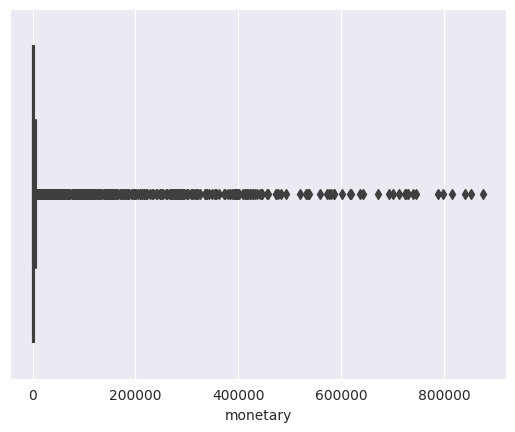

In [21]:
# checking outliers on 'monetary' column
mean = rfm_m['monetary'].mean()
std = rfm_m['monetary'].std()

# Define the threshold for outliers
threshold = 3  # Adjust this value based on your requirements

# Identify outliers
outliers = rfm_m[(np.abs(rfm_m['monetary'] - mean) > threshold * std)]

print(outliers)
# plot boxplot of 'monetary'
sns.boxplot(x='monetary', data=rfm)  # Assuming 'monetary' is a categorical variable
plt.show()

##remove outliers by monetary

In [22]:
#### removing outliers
# trim the dataset at 1 percentile and 99th percentile
# which means removing records below 1st percentile and above 99th percentile
# first, establish the 1st and 99th percentile
p1 = rfm.monetary.quantile(0.01)
p99 = rfm.monetary.quantile(0.99)
# Check the descriptive statistics to see if the numbers are better (especially monetary)
rfm[(rfm.monetary >= p1) & (rfm.monetary <= p99)].describe()

,recency,frequency,monetary
count,18851.000000,18851.000000,18851.000000
mean,190.459339,4.106838,2366.388156
std,149.985116,8.686692,8216.586379
min,0.000000,1.000000,4.990000
25%,85.000000,2.000000,54.980000
50%,166.000000,3.000000,548.980000
75%,264.000000,4.000000,2751.417500
max,1126.000000,181.000000,144602.581600


In [23]:
# apply the changes to remove records below and above 99th percentile
rfm_trimmed = rfm[(rfm['monetary'] >= p1) & (rfm['monetary'] <= p99)]
rfm_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18851 entries, 11000 to 30115
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    18851 non-null  int64  
 1   frequency  18851 non-null  int64  
 2   monetary   18851 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 589.1 KB


In [24]:
# output cleaned file so can refer to this file in the future
rfm_trimmed.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks','rfm_trimmed.csv'), index = False)

In [25]:
# use pandas profiling to check the RFM dataset
profile = ProfileReport(rfm)
profile.to_file("rfm_trimmed.csv")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas_profiling/profile_report.py:314: UserWarning: Extension .csv not supported. For now we assume .html was intended. To remove this warning, please use .html or .json.
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##clustering

In [26]:
# run clustering using pycaret
from pycaret.clustering import *
model = setup(data = rfm_trimmed)

,Description,Value
0,Session id,2700
1,Original data shape,"(18851, 3)"
2,Transformed data shape,"(18851, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [27]:
# Sillhoutte and Calinski-Harabasz, greater the better
# Davies-Boudlin record in get_metrics() is wrong, should be lower the better
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7f0cd10a9360>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7f0cd10...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7f0cd10a95a0>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7f0cd1a427a0>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7f0cd1a42680>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7f0cd1a42830>,make_scorer(completeness_score),pred,{},True,True,False


In [28]:
# create empty dataframe to store results
results = pd.DataFrame()
# run through multiple clusters to check which has the best results
# tqdm.trange allows us to see a progress bar when we use range function
from tqdm import trange

for i in trange(2, 11):
    kmeans = create_model('kmeans',
                          num_clusters=i,
                          init='k-means++',
                          n_init=10,
                          max_iter=300,
                          random_state=42
                          )
    metrics = pull()  # Extract results table into dataframe
    metrics['algo'] = 'kmeans'
    metrics['num_clusters'] = i
    results = results.append(metrics)

  0%|          | 0/9 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.9695,72692.5132,0.2827,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:06<00:52,  6.62s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.9424,68919.8558,0.4180,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:11<00:37,  5.37s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7226,92845.1816,0.4702,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:15<00:29,  4.89s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7232,105356.0028,0.4999,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:21<00:26,  5.34s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7237,115929.4907,0.4856,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:26<00:20,  5.11s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7123,140636.7277,0.4961,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [00:30<00:14,  4.89s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7141,152974.4503,0.4811,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 78%|███████▊  | 7/9 [00:35<00:09,  4.76s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7163,174778.8669,0.4715,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 89%|████████▉ | 8/9 [00:40<00:04,  4.95s/it]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7150,205176.5284,0.4822,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:47<00:00,  5.23s/it]


In [29]:
results
# check the results of mulitiple number of clusters
# Silhoutte says 2 clusters
# Calinski says 10 or more clusteres
# Davis says 2 clusters (smaller is better)
# plot model says 4

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,algo,num_clusters
0,0.9695,72692.5132,0.2827,0,0,0,kmeans,2
0,0.9424,68919.8558,0.4180,0,0,0,kmeans,3
0,0.7226,92845.1816,0.4702,0,0,0,kmeans,4
0,0.7232,105356.0028,0.4999,0,0,0,kmeans,5
0,0.7237,115929.4907,0.4856,0,0,0,kmeans,6
0,0.7123,140636.7277,0.4961,0,0,0,kmeans,7
0,0.7141,152974.4503,0.4811,0,0,0,kmeans,8
0,0.7163,174778.8669,0.4715,0,0,0,kmeans,9
0,0.7150,205176.5284,0.4822,0,0,0,kmeans,10


In [30]:
# let's go with 4 clusters
# create model based on 4 clusters
best_model = create_model(model='kmeans',
             num_clusters = 4, # tell it how many centriods you want
             init='k-means++', # how to put the initial centriods
             # put first centriod, find point furthest away and put 2nd centriod 2/3 away
             n_init=10,  # Run this 10 times and choose the one with the lowest SSE (error: sum of squares)
             # because the centriods are assigned randomly, so do it 10 times
             max_iter=300, # Max iteration 300 times
             random_state=42 )

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7226,92845.1816,0.4702,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

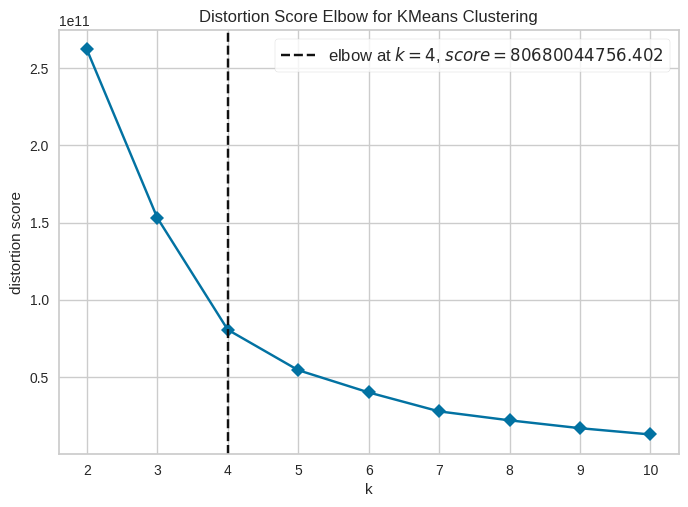

In [31]:
# plot the elbow plot to confirm 4 is recommended
plot_model(best_model, plot='elbow')

4 Clusters is determined as the best number of clusters, and the elbow plot confirms it since 4 clusters is the point of inflection where the inertia begins to level off. This point indicates the optimal number of clusters.

In [32]:
# assign the cluster number (starting from 0) to the RFM dataset
rfm_trimmed = assign_model(best_model)
rfm_trimmed.head(3)

,recency,frequency,monetary,Cluster
CustomerID,,,,
11000,270,8,8248.990234,Cluster 0
11001,49,11,6383.879883,Cluster 0
11002,339,4,8114.040039,Cluster 0


In [33]:
rfm_trimmed.Cluster.value_counts()

Cluster 2    14330
Cluster 0     4353
Cluster 3       88
Cluster 1       80
Name: Cluster, dtype: int64

<Axes: xlabel='Cluster', ylabel='recency'>

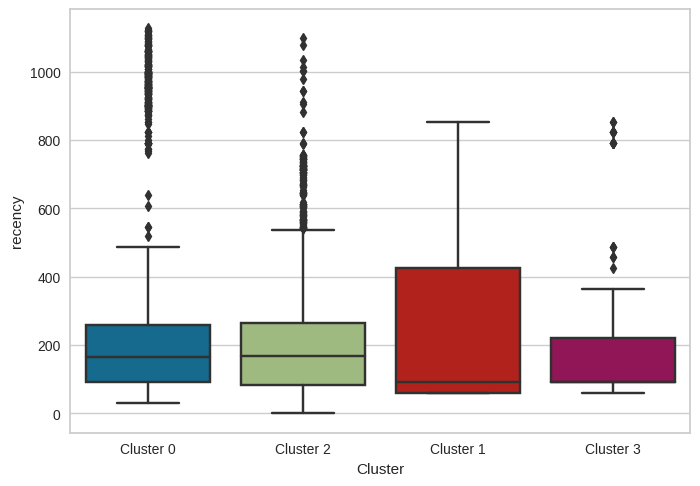

In [34]:
# Clusters vs Recency
sns.boxplot(x = 'Cluster',y = 'recency', data = rfm_trimmed)

<Axes: xlabel='Cluster', ylabel='frequency'>

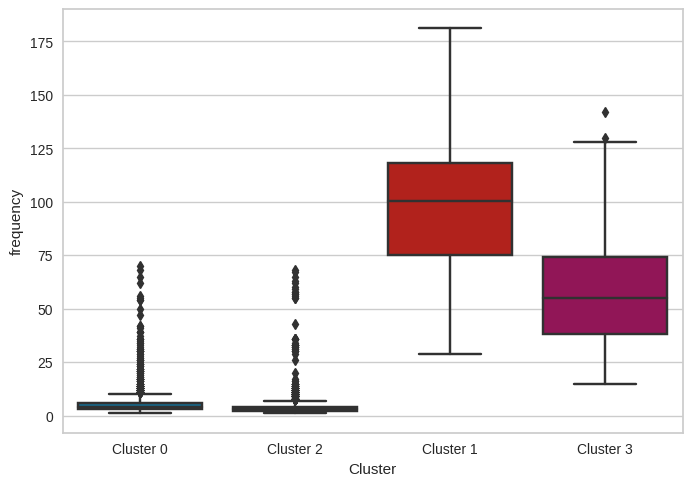

In [35]:
# Clusters vs Frequency
sns.boxplot(x = 'Cluster',y = 'frequency', data = rfm_trimmed)

<Axes: xlabel='Cluster', ylabel='monetary'>

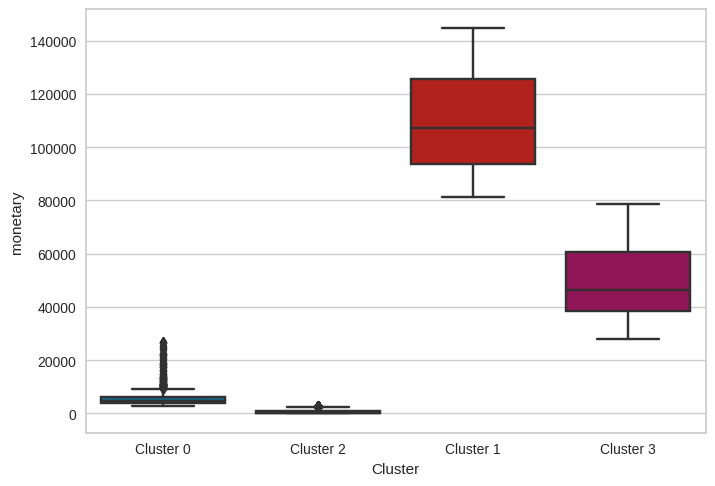

In [36]:
# Clusters vs Monetary Value
sns.boxplot(x = 'Cluster',y = 'monetary', data = rfm_trimmed)

In [37]:
# reset the index so the CustomerID becomes a column
rfm_trimmed.reset_index(drop=False, inplace=True)
rfm_trimmed.head(2)

,CustomerID,recency,frequency,monetary,Cluster
0,11000,270,8,8248.990234,Cluster 0
1,11001,49,11,6383.879883,Cluster 0


##calculate lifetime value per customer

In [38]:
# calculate the average spend value per customer by taking monetary (total amount spent) / frequency (how many times spent)
rfm_trimmed['ASV_per_customer'] = rfm_trimmed.monetary / rfm_trimmed.frequency
rfm_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18851 entries, 0 to 18850
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        18851 non-null  int64  
 1   recency           18851 non-null  int32  
 2   frequency         18851 non-null  int32  
 3   monetary          18851 non-null  float32
 4   Cluster           18851 non-null  object 
 5   ASV_per_customer  18851 non-null  float64
dtypes: float32(1), float64(1), int32(2), int64(1), object(1)
memory usage: 662.9+ KB


In [39]:
# calculate the maximum number of days in the dataset
min_date = sohd_df['OrderDate'].min()
max_date = sohd_df['OrderDate'].max()
max_no_days = (max_date - min_date).days
max_no_days

1126

In [40]:
# find out how long the company has been serving each customer: years of service
# max_no_days - recency
rfm_trimmed['years_of_service'] = (max_no_days - rfm_trimmed['recency']) / 365
rfm_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18851 entries, 0 to 18850
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        18851 non-null  int64  
 1   recency           18851 non-null  int32  
 2   frequency         18851 non-null  int32  
 3   monetary          18851 non-null  float32
 4   Cluster           18851 non-null  object 
 5   ASV_per_customer  18851 non-null  float64
 6   years_of_service  18851 non-null  float64
dtypes: float32(1), float64(2), int32(2), int64(1), object(1)
memory usage: 810.1+ KB


In [52]:
# calculate lifetime value
# average spend value * years of service
rfm_trimmed['lifetime_value'] = rfm_trimmed['ASV_per_customer'] * rfm_trimmed['years_of_service']
rfm_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18851 entries, 0 to 18850
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        18851 non-null  int64  
 1   recency           18851 non-null  int32  
 2   frequency         18851 non-null  int32  
 3   monetary          18851 non-null  float32
 4   Cluster           18851 non-null  object 
 5   ASV_per_customer  18851 non-null  float64
 6   years_of_service  18851 non-null  float64
 7   lifetime_value    18851 non-null  float64
dtypes: float32(1), float64(3), int32(2), int64(1), object(1)
memory usage: 957.4+ KB


##get in customer demographics

In [58]:
# read in Sales vPersonDemographics to get Customer demographics
sales_vperson_demographics_df = pd.read_excel(os.path.join(data_path, filename),sheet_name='Sales vPersonDemographics')
sales_vperson_demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19972 entries, 0 to 19971
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   BusinessEntityID      19972 non-null  int64         
 1   TotalPurchaseYTD      19972 non-null  float64       
 2   DateFirstPurchase     18484 non-null  datetime64[ns]
 3   BirthDate             18484 non-null  datetime64[ns]
 4   MaritalStatus         18484 non-null  object        
 5   YearlyIncome          18484 non-null  object        
 6   Gender                18484 non-null  object        
 7   TotalChildren         18484 non-null  float64       
 8   NumberChildrenAtHome  18484 non-null  float64       
 9   Education             18484 non-null  object        
 10  Occupation            18484 non-null  object        
 11  HomeOwnerFlag         18484 non-null  float64       
 12  NumberCarsOwned       18484 non-null  float64       
dtypes: datetime64[ns

In [59]:
# merge to SalesCustomer to get CustomerID into Person Demographics
Sales_Demo = pd.merge(sales_customer_df, sales_vperson_demographics_df, left_on='PersonID', right_on='BusinessEntityID')
Sales_Demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19119 entries, 0 to 19118
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            19119 non-null  int64         
 1   PersonID              19119 non-null  float64       
 2   StoreID               635 non-null    float64       
 3   TerritoryID           19119 non-null  int64         
 4   AccountNumber         19119 non-null  object        
 5   rowguid               19119 non-null  object        
 6   ModifiedDate          19119 non-null  datetime64[ns]
 7   BusinessEntityID      19119 non-null  int64         
 8   TotalPurchaseYTD      19119 non-null  float64       
 9   DateFirstPurchase     18484 non-null  datetime64[ns]
 10  BirthDate             18484 non-null  datetime64[ns]
 11  MaritalStatus         18484 non-null  object        
 12  YearlyIncome          18484 non-null  object        
 13  Gender          

In [60]:
# Check for missing data
missing_data = Sales_Demo.isnull()
missing_count = missing_data.sum()
print("Missing values per column:")
print(missing_count)

Missing values per column:
CustomerID                  0
PersonID                    0
StoreID                 18484
TerritoryID                 0
AccountNumber               0
rowguid                     0
ModifiedDate                0
BusinessEntityID            0
TotalPurchaseYTD            0
DateFirstPurchase         635
BirthDate                 635
MaritalStatus             635
YearlyIncome              635
Gender                    635
TotalChildren             635
NumberChildrenAtHome      635
Education                 635
Occupation                635
HomeOwnerFlag             635
NumberCarsOwned           635
dtype: int64


In [61]:
# drop whole null row of StoreID
Sales_Demo = Sales_Demo.drop('StoreID', axis=1)
Sales_Demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19119 entries, 0 to 19118
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            19119 non-null  int64         
 1   PersonID              19119 non-null  float64       
 2   TerritoryID           19119 non-null  int64         
 3   AccountNumber         19119 non-null  object        
 4   rowguid               19119 non-null  object        
 5   ModifiedDate          19119 non-null  datetime64[ns]
 6   BusinessEntityID      19119 non-null  int64         
 7   TotalPurchaseYTD      19119 non-null  float64       
 8   DateFirstPurchase     18484 non-null  datetime64[ns]
 9   BirthDate             18484 non-null  datetime64[ns]
 10  MaritalStatus         18484 non-null  object        
 11  YearlyIncome          18484 non-null  object        
 12  Gender                18484 non-null  object        
 13  TotalChildren   

In [62]:
# drop customers without demographics
Sales_Demo.dropna(subset=['MaritalStatus'], inplace=True)
Sales_Demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 18483
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            18484 non-null  int64         
 1   PersonID              18484 non-null  float64       
 2   TerritoryID           18484 non-null  int64         
 3   AccountNumber         18484 non-null  object        
 4   rowguid               18484 non-null  object        
 5   ModifiedDate          18484 non-null  datetime64[ns]
 6   BusinessEntityID      18484 non-null  int64         
 7   TotalPurchaseYTD      18484 non-null  float64       
 8   DateFirstPurchase     18484 non-null  datetime64[ns]
 9   BirthDate             18484 non-null  datetime64[ns]
 10  MaritalStatus         18484 non-null  object        
 11  YearlyIncome          18484 non-null  object        
 12  Gender                18484 non-null  object        
 13  TotalChildren   

In [63]:
#Confirm that missing data is dropped
missing_data = Sales_Demo.isnull()
missing_count = missing_data.sum()
print("Missing values per column:")
print(missing_count)

Missing values per column:
CustomerID              0
PersonID                0
TerritoryID             0
AccountNumber           0
rowguid                 0
ModifiedDate            0
BusinessEntityID        0
TotalPurchaseYTD        0
DateFirstPurchase       0
BirthDate               0
MaritalStatus           0
YearlyIncome            0
Gender                  0
TotalChildren           0
NumberChildrenAtHome    0
Education               0
Occupation              0
HomeOwnerFlag           0
NumberCarsOwned         0
dtype: int64


In [64]:
# merge customer demographics to RFM dataset by CustomerID
demo_rfm = pd.merge(Sales_Demo, rfm_trimmed, on="CustomerID")
demo_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18409 entries, 0 to 18408
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerID            18409 non-null  int64         
 1   PersonID              18409 non-null  float64       
 2   TerritoryID           18409 non-null  int64         
 3   AccountNumber         18409 non-null  object        
 4   rowguid               18409 non-null  object        
 5   ModifiedDate          18409 non-null  datetime64[ns]
 6   BusinessEntityID      18409 non-null  int64         
 7   TotalPurchaseYTD      18409 non-null  float64       
 8   DateFirstPurchase     18409 non-null  datetime64[ns]
 9   BirthDate             18409 non-null  datetime64[ns]
 10  MaritalStatus         18409 non-null  object        
 11  YearlyIncome          18409 non-null  object        
 12  Gender                18409 non-null  object        
 13  TotalChildren   

##regression

In [65]:
# run the prediction model
# since lifetime_value is a numeric variable
# we should be using regression

# import pycaret regression module
from pycaret.regression import *
regression = setup(data = demo_rfm, target = 'lifetime_value', session_id=42)

,Description,Value
0,Session id,42
1,Target,lifetime_value
2,Target type,Regression
3,Original data shape,"(18409, 26)"
4,Transformed data shape,"(18409, 44)"
5,Transformed train set shape,"(12886, 44)"
6,Transformed test set shape,"(5523, 44)"
7,Ordinal features,3
8,Numeric features,14
9,Date features,3


In [66]:
# compare models
# sort such that the model with the lowest MAPE is on top
best = compare_models(exclude = ['ransac'], sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,292.2891,303331.1594,550.2255,0.8722,0.6008,0.5952,0.9580
omp,Orthogonal Matching Pursuit,344.0127,478993.5368,689.2732,0.7974,0.9498,1.7137,0.9550
catboost,CatBoost Regressor,1090.9356,2026146.5278,1422.8702,0.1462,2.2109,12.4918,6.8760
et,Extra Trees Regressor,1114.2022,2006537.3176,1415.8605,0.1547,2.2471,13.3686,8.9410
huber,Huber Regressor,1163.9534,2079643.8958,1432.9589,0.1251,2.3282,15.2702,0.9840
llar,Lasso Least Angle Regression,1215.7942,2258164.3968,1499.1308,0.0482,2.3657,15.9120,0.5980
lightgbm,Light Gradient Boosting Machine,1249.4164,2363602.4573,1536.9601,0.0037,2.3894,16.3446,1.0580
xgboost,Extreme Gradient Boosting,1251.5767,2371303.7750,1539.4582,0.0005,2.3914,16.3897,3.8090
gbr,Gradient Boosting Regressor,1252.2616,2372027.8712,1539.7035,0.0001,2.3923,16.4139,4.6160
ridge,Ridge Regression,1252.8813,2374066.9774,1540.3620,-0.0007,2.3929,16.4253,1.1750


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [67]:
# create the best model
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,279.6920,284972.9688,533.8286,0.8749,0.6082,0.6106
1,302.2018,319680.0000,565.4025,0.8781,0.5870,0.6124
2,296.3035,322866.4375,568.2134,0.8704,0.5886,0.5958
3,306.5982,332484.9062,576.6151,0.8552,0.5898,0.5429
4,294.2954,311563.0312,558.1783,0.8708,0.6435,0.6280
5,297.2307,335555.0312,579.2711,0.8605,0.6230,0.6133
6,278.6295,274645.5312,524.0663,0.8789,0.6081,0.6377
7,274.6086,259815.5000,509.7210,0.8832,0.5879,0.5824
8,287.9825,271695.2188,521.2439,0.8831,0.5821,0.5497


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
tuned_knn = tune_model(knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,278.3019,278727.0000,527.9460,0.8776,0.6093,0.6046
1,295.5542,301203.5625,548.8201,0.8852,0.5845,0.6080
2,294.9221,318876.6875,564.6917,0.8720,0.5890,0.6012
3,305.6787,330389.0625,574.7948,0.8561,0.5912,0.5420
4,289.4066,302582.8750,550.0753,0.8745,0.6410,0.6283
5,294.3900,323608.5938,568.8661,0.8655,0.6220,0.6115
6,279.2911,275506.8750,524.8875,0.8785,0.6099,0.6418
7,269.6802,251360.6719,501.3588,0.8870,0.5883,0.5730
8,285.9093,271423.6562,520.9833,0.8832,0.5837,0.5543


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


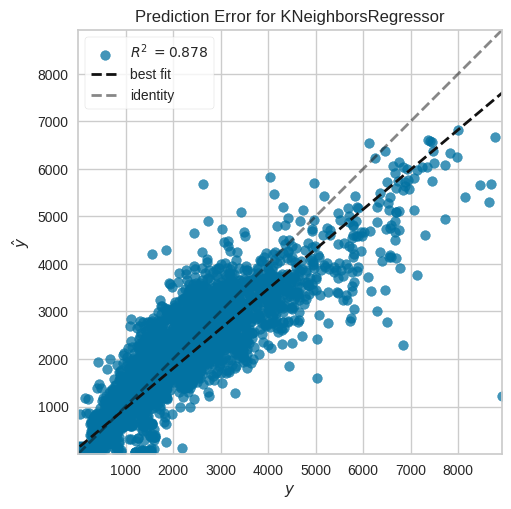

In [70]:
# plot the feature importance of the best model
plot_model(knn, plot = 'error')
# plot_model(knn, plot = 'feature')

In [71]:
demo_rfm.Cluster.value_counts()

Cluster 2    14241
Cluster 0     4168
Name: Cluster, dtype: int64

In [72]:
# since cluster 2 is the most important
# extract out cluster 2 customer demographics and compare to the biggest cluster (cluster 0)
cluster_2_data = demo_rfm[demo_rfm['Cluster'] == 'Cluster 2']
cluster_0_data = demo_rfm[demo_rfm['Cluster'] == 'Cluster 0']

In [73]:
# run pandas profiling on cluster 2
profile_cluster_2 = ProfileReport(cluster_2_data, title="Pandas Profiling Report - Cluster 2")
profile_cluster_2.to_file("cluster_2_report.html")
profile_cluster_2

Output hidden; open in https://colab.research.google.com to view.

In [74]:
# run pandas profiling on cluster 0
profile_Cluster_0 = ProfileReport(cluster_0_data, title="Pandas Profiling Report - Cluster 0")
profile_Cluster_0.to_file("cluster_0_report.html")
profile_Cluster_0

Output hidden; open in https://colab.research.google.com to view.

In [76]:
#### Comparison of Cluster 2 to Cluster 0

# higher TotalPurchaseYTD compared to cluster 0
TotalPurchaseYTD_median_2 = np.median(cluster_2_data['TotalPurchaseYTD'])
TotalPurchaseYTD_median_0 = np.median(cluster_0_data['TotalPurchaseYTD'])
if TotalPurchaseYTD_median_2 > TotalPurchaseYTD_median_0:
  print(f"Cluster 2 has a median of {TotalPurchaseYTD_median_2}")
  print(f"Cluster 0 has a median of {TotalPurchaseYTD_median_0}")
  print("Cluster 2 has a higher TotalPurchaseYTD based on it's median")
else:
  print(f"Cluster 2 has a median of {TotalPurchaseYTD_median_2}")
  print(f"Cluster 0 has a median of {TotalPurchaseYTD_median_0}")
  print("Cluster 0 has a higher TotalPurchaseYTD based on it's median")

Cluster 2 has a median of 15.49
Cluster 0 has a median of 707.36
Cluster 0 has a higher TotalPurchaseYTD based on it's median


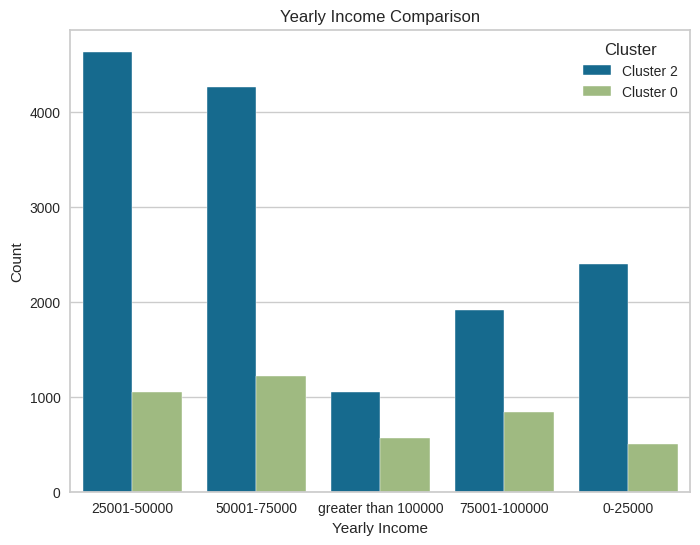

In [77]:
# more 50-75k YearlyIncome
plt.figure(figsize=(8, 6))
sns.countplot(x='YearlyIncome', hue='Cluster', data=demo_rfm)
plt.title('Yearly Income Comparison')
plt.xlabel('Yearly Income')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

In [78]:
more_than_50K_c2 = cluster_2_data[~cluster_2_data['YearlyIncome'].isin(['0-25000', '25001-50000'])]
more_than_50K_count_c2 = more_than_50K_c2['YearlyIncome'].count()

more_than_50K_c0 = cluster_0_data[~cluster_0_data['YearlyIncome'].isin(['0-25000', '25001-50000'])]
more_than_50K_count_c0 = more_than_50K_c0['YearlyIncome'].count()



#do i compare cluster 2 & 0 via percentage? as cluster size is different
if more_than_50K_count_c2 > more_than_50K_count_c0:
  result = more_than_50K_count_c2 - more_than_50K_count_c0
  print(f"Cluster 2 has a total of {more_than_50K_count_c2} customers with yearly income more than 50K")
  print(f"Cluster 0 has a total of {more_than_50K_count_c0} customers with yearly income more than 50K")
  print(f"Cluster 2 has more customers with yearly income over 50K than Cluster 0, by {result}")
else:
  more_than_50K_count_c0 > more_than_50K_count_c2
  result = more_than_50K_count_c0 - more_than_50K_count_c2
  print(f"Cluster 2 has a total of {more_than_50K_count_c2} customers with yearly income more than 50K")
  print(f"Cluster 0 has a total of {more_than_50K_count_c0} customers with yearly income more than 50K")
  print(f"Cluster 2 has more customers with yearly income over 50K than Cluster 0, by {result}")

Cluster 2 has a total of 7221 customers with yearly income more than 50K
Cluster 0 has a total of 2621 customers with yearly income more than 50K
Cluster 2 has more customers with yearly income over 50K than Cluster 0, by 4600


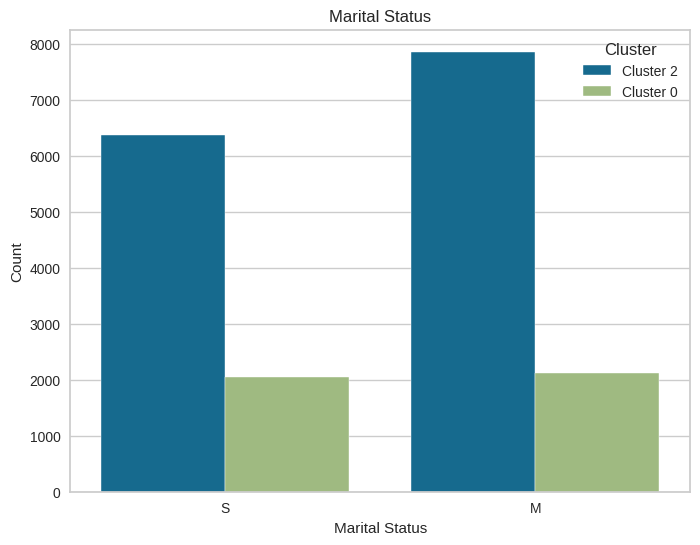

In [79]:
# higher % of bachelors
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', hue='Cluster', data=demo_rfm)
plt.title('Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

In [84]:
single_c2 = cluster_2_data[~cluster_2_data['MaritalStatus'].isin(['M'])]
single_c2_count = single_c2['MaritalStatus'].count()
single_c2_count_per = (single_c2_count/14241)*100

single_c0 = cluster_0_data[~cluster_0_data['MaritalStatus'].isin(['M'])]
single_c0_count = single_c0['MaritalStatus'].count()
single_c0_count_per = (single_c0_count/4168)*100


if single_c2_count_per > single_c0_count_per:
  result = round(single_c2_count_per - single_c0_count_per , 2)
  print(f"Cluster 2 has {single_c2_count} single customers")
  print(f"Cluster 2 has more single customers than Cluster 0, by {result}%")
else:
  single_c0_count_per > single_c2_count_per
  result = round(single_c0_count_per - single_c2_count_per , 2)
  print(f"Cluster 0 has {single_c0_count} single customers")
  print(f"Cluster 0 has more single customers than Cluster 2, by {result}%")

Cluster 0 has 2054 single customers
Cluster 0 has more single customers than Cluster 2, by 4.52%


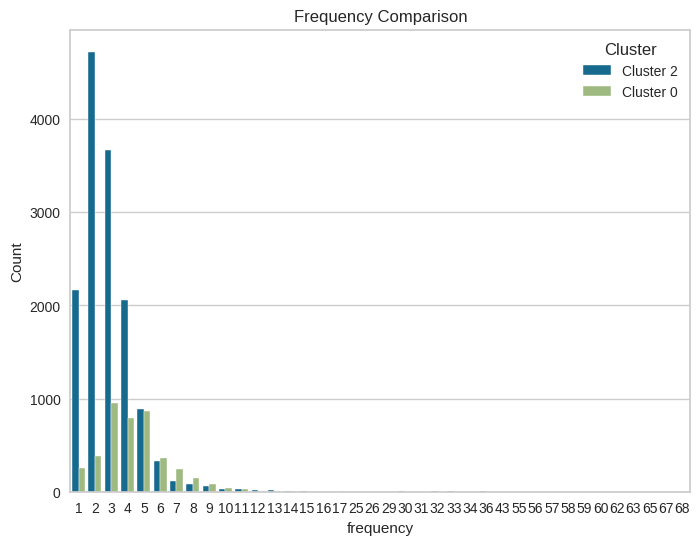

In [99]:
plt.figure(figsize=(8, 6))
sns.countplot(x='frequency', hue='Cluster', data=demo_rfm)
plt.title('Frequency Comparison')
plt.xlabel('frequency')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

In [104]:
frequency_median_2 = np.median(cluster_2_data['frequency'])
frequency_median_0 = np.median(cluster_0_data['frequency'])

print("Frequency median for Cluster 2:", frequency_median_2)
print("Frequency median for Cluster 0:", frequency_median_0)

if frequency_median_2 > frequency_median_0:
  print(f"Cluster 2 has a higher frequency value of {frequency_median_2} based on it's median")
else:
  print(f"Cluster 0 has a higher frequency valueof {frequency_median_0} based on it's median")

Frequency median for Cluster 2: 3.0
Frequency median for Cluster 0: 4.0
Cluster 0 has a higher frequency valueof 4.0 based on it's median


In [93]:
monetary_median_2 = np.median(cluster_2_data['monetary'])
monetary_median_0 = np.median(cluster_0_data['monetary'])

print("Monetary median for Cluster 2:", monetary_median_2)
print("Monetary median for Cluster 0:", monetary_median_0)

if monetary_median_2 > monetary_median_0:
  print(f"Cluster 2 has a higher monetary value of {monetary_median_2} based on it's median")
else:
  print(f"Cluster 0 has a higher monetary value of {monetary_median_0} based on it's median")

Monetary median for Cluster 2: 86.95
Monetary median for Cluster 0: 4660.702
Cluster 0 has a higher monetary value of 4660.7021484375 based on it's median


In [95]:
lifetime_value_median_2 = np.median(cluster_2_data['lifetime_value'])
lifetime_value_median_0 = np.median(cluster_0_data['lifetime_value'])

print("Lifetime value median for Cluster 2:", lifetime_value_median_2)
print("Lifetime value median for Cluster 0:", lifetime_value_median_0)

if lifetime_value_median_2 > lifetime_value_median_0:
  print(f"Cluster 2 has a higher monetary value of {lifetime_value_median_2} based on it's median")
else:
  print(f"Cluster 0 has a higher monetary value of {lifetime_value_median_0} based on it's median")

Lifetime value median for Cluster 2: 77.0779720045116
Lifetime value median for Cluster 0: 2894.729061162243
Cluster 0 has a higher monetary value of 2894.729061162243 based on it's median
